In [265]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import re
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [266]:

# accepted2 = pd.read_csv('C:\\Users\\nilli\\Downloads\\accepted_b_2015.csv',
#                        low_memory = False, dtype = dtypes, parse_dates = parse_dates)
parse_dates = ['issue_d', 'last_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d']

accepted = pd.read_csv('C:\\Users\\nilli\\Downloads\\accepted_b_2015.csv',
                        parse_dates = parse_dates)

In [267]:
accepted["term"] = accepted["term"].apply(lambda x: re.sub('months', '',x)).astype('int64')  

In [268]:
accepted["emp_length"] = accepted['emp_length'].apply(lambda x: re.sub('years', '',x))#.astype('int64')
accepted["emp_length"] = accepted['emp_length'].apply(lambda x: re.sub('year', '',x))
accepted["emp_length"] = accepted['emp_length'].apply(lambda x: re.sub('< 1 ', '0',x))
accepted["emp_length"] = accepted["emp_length"].str.replace(r'\D', '', ).astype('int64')

In [269]:
grade_ord = {'A': 7,'B': 6,'C': 5,'D': 4,'E': 3,'F': 2,'G': 1}
accepted['grade']= accepted['grade'].map(grade_ord)   

In [270]:
post_loan_columns = ['verification_status', 'loan_status', 'out_prncp',
                     'total_pymnt','total_rec_prncp','total_rec_int',
                     'total_rec_late_fee', 'recoveries', 
                     'collection_recovery_fee', 'last_pymnt_d',
                     'last_pymnt_amnt','last_credit_pull_d', 
                     'last_fico_range_high','last_fico_range_low',
                     'duration_days','duration_months','invest_return_per',
                     'invest_return']

In [271]:
#Remove from features
remove_columns = ['issue_d', 'id','earliest_cr_line', 'initial_list_status']


#Count columns
counting_columns = ['delinq_2yrs','inq_last_6mths', 'open_acc', 
                    'pub_rec', 'total_acc', 'collections_12_mths_ex_med', 
                    'acc_now_delinq', 'chargeoff_within_12_mths', 
                    'mort_acc','num_accts_ever_120_pd', 'num_actv_bc_tl', 
                    'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
                    'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
                    'num_tl_120dpd_2m', 'num_tl_30dpd','num_tl_90g_dpd_24m', 
                    'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens',
                    'acc_open_past_24mths', 'num_actv_rev_tl']


# Categorical
cat_columns = ['term', 'home_ownership', 'purpose','addr_state'] #'initial_list_status']

#Ordinal
ordinal_columns = ['grade', 'sub_grade', 'emp_length']

#earliest_cr_line is a datetime column. The rest is the number of months since something
time_columns = ['mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 
                'mths_since_recent_bc','mo_sin_rcnt_rev_tl_op'] # removing,'earliest_cr_line']

non_continuous_columns = counting_columns + cat_columns + ordinal_columns + time_columns
continuous_columns = ['loan_amnt','int_rate',
                      'installment','annual_inc','dti',
                      'fico_range_low','fico_range_high',
                      'revol_bal','revol_util','tot_coll_amt',
                      'tot_cur_bal','total_rev_hi_lim',
                      'avg_cur_bal','bc_open_to_buy','bc_util',
                      'delinq_amnt','pct_tl_nvr_dlq',
                      'percent_bc_gt_75','tot_hi_cred_lim',
                      'total_bal_ex_mort','total_bc_limit',
                      'total_il_high_credit_limit'] # removing 'funded_amnt',

feature_columns = continuous_columns + non_continuous_columns

In [272]:
import category_encoders as ce

sub_grades = sorted(accepted['sub_grade'].unique())
sub_grade_map = {e:i for i, e in enumerate(sub_grades)}

emp_lengths = sorted(accepted['emp_length'].unique())
emp_length_map = {e:i for i, e in zip([1, 10, 2, 3, 4, 5, 6, 7, 8, 9, 0], emp_lengths)}


mapping=[{'col':'sub_grade' , 'mapping':sub_grade_map}, 
         {'col':'emp_length', 'mapping':emp_length_map}]

for col in cat_columns:
    col_map = {e:i for i, e in enumerate(sorted(accepted[col].unique()))}
    mapping.append({'col':col, 'mapping': col_map})

# dropping grade since it is redundant with sub_grade
# accepted.drop(columns = 'grade', inplace = True)
# ordinal_columns.remove('grade')
# feature_columns.remove('grade')
# non_continuous_columns.remove('grade')


# # dropping sub_grade since it is redundant with grade
# accepted.drop(columns = 'sub_grade', inplace = True)
# ordinal_columns.remove('sub_grade')
# feature_columns.remove('sub_grade')
# non_continuous_columns.remove('sub_grade')


In [273]:
loan_status_cat_ord = {'Defaulted':0, 'FullyPaid':1}
accepted['loan_status'] = accepted['loan_status'].map(loan_status_cat_ord) 

In [274]:
encoder = ce.OrdinalEncoder(cols= cat_columns + ordinal_columns, 
                            mapping=mapping)

Y = accepted['loan_status']

encoder.fit(accepted, Y)

encoder.transform(accepted)[feature_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453776 entries, 0 to 453775
Data columns (total 59 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   453776 non-null  float64
 1   int_rate                    453776 non-null  float64
 2   installment                 453776 non-null  float64
 3   annual_inc                  453776 non-null  float64
 4   dti                         453776 non-null  float64
 5   fico_range_low              453776 non-null  float64
 6   fico_range_high             453776 non-null  float64
 7   revol_bal                   453776 non-null  float64
 8   revol_util                  453776 non-null  float64
 9   tot_coll_amt                453776 non-null  float64
 10  tot_cur_bal                 453776 non-null  float64
 11  total_rev_hi_lim            453776 non-null  float64
 12  avg_cur_bal                 453776 non-null  float64
 13  bc_open_to_buy

In [233]:
# accepted[feature_columns].columns
# accepted.drop(columns = ['sub_grade','earliest_cr_line'], inplace = True)

In [275]:
X = accepted[feature_columns] 
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_bal,revol_util,tot_coll_amt,...,home_ownership,purpose,addr_state,grade,sub_grade,emp_length,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mo_sin_rcnt_rev_tl_op
0,10400.0,6.99,321.08,58000.0,14.92,710.0,714.0,6133.0,31.6,0.0,...,MORTGAGE,credit_card,CA,7,A3,8,290.0,1.0,5.0,1.0
1,15000.0,12.39,336.64,78000.0,12.03,750.0,754.0,138008.0,29.0,0.0,...,RENT,debt_consolidation,VA,5,C1,10,244.0,1.0,47.0,1.0
2,9600.0,13.66,326.53,69000.0,25.81,680.0,684.0,16388.0,59.4,0.0,...,RENT,debt_consolidation,NJ,5,C3,10,265.0,3.0,24.0,23.0
3,7650.0,13.66,260.20,50000.0,34.81,685.0,689.0,16822.0,91.9,0.0,...,RENT,debt_consolidation,AZ,5,C3,0,148.0,8.0,17.0,8.0
4,21425.0,15.59,516.36,63800.0,18.49,685.0,689.0,16374.0,76.2,0.0,...,RENT,credit_card,MO,4,D1,6,136.0,7.0,7.0,7.0


In [235]:
# 2015 - accepted['earliest_cr_line'].dt.year

In [236]:
# y = accepted['loan_status']
# y

In [237]:
# accepted.columns

In [276]:
X.select_dtypes(include = 'object').columns

Index(['home_ownership', 'purpose', 'addr_state', 'sub_grade'], dtype='object')

In [277]:
X= X.drop('sub_grade', axis =1)
X

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_bal,revol_util,tot_coll_amt,...,term,home_ownership,purpose,addr_state,grade,emp_length,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mo_sin_rcnt_rev_tl_op
0,10400.0,6.99,321.08,58000.0,14.92,710.0,714.0,6133.0,31.6,0.0,...,36,MORTGAGE,credit_card,CA,7,8,290.0,1.0,5.0,1.0
1,15000.0,12.39,336.64,78000.0,12.03,750.0,754.0,138008.0,29.0,0.0,...,60,RENT,debt_consolidation,VA,5,10,244.0,1.0,47.0,1.0
2,9600.0,13.66,326.53,69000.0,25.81,680.0,684.0,16388.0,59.4,0.0,...,36,RENT,debt_consolidation,NJ,5,10,265.0,3.0,24.0,23.0
3,7650.0,13.66,260.20,50000.0,34.81,685.0,689.0,16822.0,91.9,0.0,...,36,RENT,debt_consolidation,AZ,5,0,148.0,8.0,17.0,8.0
4,21425.0,15.59,516.36,63800.0,18.49,685.0,689.0,16374.0,76.2,0.0,...,60,RENT,credit_card,MO,4,6,136.0,7.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453771,20500.0,16.77,728.54,60000.0,16.40,700.0,704.0,15417.0,58.4,0.0,...,36,RENT,debt_consolidation,NY,4,7,155.0,5.0,13.0,7.0
453772,15000.0,15.27,521.97,57600.0,8.35,680.0,684.0,8897.0,33.1,0.0,...,36,RENT,small_business,CA,5,3,163.0,6.0,14.0,8.0
453773,35000.0,15.96,1229.81,160000.0,4.90,720.0,724.0,23665.0,62.4,0.0,...,36,MORTGAGE,small_business,CA,5,3,162.0,5.0,14.0,8.0
453774,12000.0,16.29,423.61,35000.0,12.93,675.0,679.0,15006.0,93.2,0.0,...,36,MORTGAGE,other,TX,4,5,158.0,5.0,13.0,7.0


In [278]:
from sklearn.preprocessing import OneHotEncoder

#dummify purpose column
purpose_ohe = OneHotEncoder( drop='first', sparse = False )
purpose_enc = purpose_ohe.fit_transform( X[['purpose']] )
purpose_enc = pd.DataFrame( purpose_enc, columns=purpose_ohe.get_feature_names(['purpose']) )
X= pd.concat( (X.drop(["purpose"], axis=1).reset_index(drop = True), purpose_enc), axis = 1 )

#dummify home_ownership column 
home_ownership_ohe = OneHotEncoder( drop='first', sparse = False )
home_ownership_enc = home_ownership_ohe.fit_transform( X[['home_ownership']] )
home_ownership_enc = pd.DataFrame( home_ownership_enc, columns=home_ownership_ohe.get_feature_names(['home_ownership']) )
X= pd.concat( (X.drop(["home_ownership"], axis=1).reset_index(drop = True), home_ownership_enc), axis = 1 )

#dummify addr_state column 
addr_state_ohe = OneHotEncoder( drop='first', sparse = False )
addr_state_enc = addr_state_ohe.fit_transform( X[['addr_state']] )
addr_state_enc = pd.DataFrame( addr_state_enc, columns=addr_state_ohe.get_feature_names(['addr_state']) )
X= pd.concat( (X.drop(['addr_state'], axis=1).reset_index(drop = True), addr_state_enc), axis = 1 )


In [279]:
#X = accepted[feature_columns]
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_bal,revol_util,tot_coll_amt,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,10400.0,6.99,321.08,58000.0,14.92,710.0,714.0,6133.0,31.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15000.0,12.39,336.64,78000.0,12.03,750.0,754.0,138008.0,29.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,9600.0,13.66,326.53,69000.0,25.81,680.0,684.0,16388.0,59.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7650.0,13.66,260.20,50000.0,34.81,685.0,689.0,16822.0,91.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21425.0,15.59,516.36,63800.0,18.49,685.0,689.0,16374.0,76.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [280]:
X.shape

(453776, 122)

In [281]:
Y =accepted['loan_status']


In [282]:
Xtrain, Xtest, ytrain, ytest = train_test_split( X,Y, test_size = 0.2 ,random_state=42, stratify = Y )
print(Xtrain.shape)
print(ytrain.shape)

(363020, 122)
(363020,)


In [247]:
# ss = StandardScaler()
# Xtrain = pd.DataFrame( ss.fit_transform(Xtrain), columns = Xtrain.columns)
# Xtrain.head()
# Xtest = pd.DataFrame( ss.fit_transform(Xtest), columns = Xtest.columns)
# Xtest.head()

In [283]:
from sklearn.metrics import classification_report, roc_auc_score

In [284]:
randomForest =RandomForestClassifier(class_weight="balanced",random_state=42)

In [285]:
grid_para_forest = [{
    "n_estimators": [1000],
     'max_depth' : [8],
    "criterion": ["gini"],
    'max_features': ['sqrt'],
    "min_samples_leaf": [ 4],
    "min_samples_split": [ 8],
    "random_state": [42]}]

# max_depth': 12,
#                   'max_features': 'sqrt',
#                   'max_leaf_nodes': None,
#                   'min_impurity_decrease': 0.0,
#                   'min_samples_leaf': 4,
#                   'min_samples_split': 8,
#                   'n_estimators': 1100
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5, n_jobs=-1)
%time grid_search_forest.fit(Xtrain, ytrain)

Wall time: 23min 52s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                            

In [286]:
grid_search_forest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 1000,
 'random_state': 42}

In [287]:
confusion_matrix(ytest, grid_search_forest.predict(Xtest))

array([[10506,  5010],
       [29175, 46065]], dtype=int64)

In [288]:
grid_search_forest.best_score_

0.6233761225276845

In [289]:
print(classification_report(ytest, grid_search_forest.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.26      0.68      0.38     15516
           1       0.90      0.61      0.73     75240

    accuracy                           0.62     90756
   macro avg       0.58      0.64      0.56     90756
weighted avg       0.79      0.62      0.67     90756



In [290]:
rocrf=roc_auc_score(ytest, grid_search_forest.predict_proba(Xtest)[:,1])
rocrf

0.701540654677739

In [293]:
randomForest.set_params(random_state=42, n_estimators=500, max_features=8)
randomForest.fit(Xtrain, ytrain) 
randomForest.score(Xtrain, ytrain)

1.0

<Figure size 864x1152 with 0 Axes>

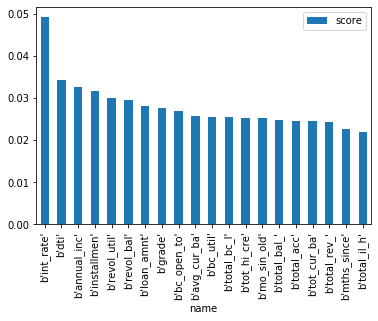

<Figure size 864x1152 with 0 Axes>

In [294]:
feature_importance = list(zip(Xtrain.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')


plt.figure(figsize=(12,16))
